# Imports

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import squarify
import spacy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

Dowanload and load catalan stopwords from `spacy`.

In [2]:
!python -m spacy download ca_core_news_sm
nlp = spacy.load("ca_core_news_sm")
stopwords = nlp.Defaults.stop_words
print(stopwords)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 33.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('ca_core_news_sm')
{'de', 'sóc', 'tan', 'nostra', 'seva', 'faig', 'ma', 'tota', "s'ha", 'consigueixen', 'pas', 'entre', 'seves', 'poder', 'quan', 'sota', 'una', 'jo', 'podem', "n'hi", 'ta', 'el', 'tenir', 'apa', 'algunes', 'esteu', 'fora', 'fas', 'ús', 'vostres', 'ses', 'vam', 'soc', 'sa', 'cada', "d'una", "d'unes", 'i', 'alhora', 'quins', "t'han", 'e', 'te', 'consigueixes', 'tenim', 'mode', 'sobre', 'un', 'tantes', 'teus', 'igual', 'veu', 'com', 'inclòs', 'iguals', 'tene', 'potser', 'és', 'tinc', 'cadascuna', 'va', 'mon', 'aquella', "d'uns", 'així', 'has', 'som', 'mateixa', 'propi', 'estem', 'a', 'ans', 'ets', "t'ha", 'fa', 'nostres', "t'he", 'fi', 'tampoc', 'seu', 'poc', 'nosaltres', 'heu', 'nostre', 'on', 'totes', 'solament', 'em', 'consegueixo', 'era', 'estaven', 'fins', 'per', 'quelcom', 'estava', 'sols', 'mat

# Load and process csv data

In [3]:
data = pd.read_csv('../data/train.csv')

In [4]:
texts = data['text']
labels = data['class']
year = data['year']

In [5]:
type(labels)

pandas.core.series.Series

## Remove stopwords + leading and trailing quotes

In [6]:
def remove_stopwords(sentence):
    sentence = ' '.join([word for word in sentence.split() if word not in stopwords])

    return sentence

preprocessed_texts = []
for sentence in texts:
    preprocessed_texts.append(remove_stopwords(sentence))

In [7]:
for sentence in preprocessed_texts:
    if sentence.startswith(("'", '"')):
        sentence = sentence[1:]
    if sentence.endswith(("'", '"')):
        sentence = sentence[:-1]

In [8]:
print(np.random.choice(preprocessed_texts, 15, replace=False))

['Aprovació definitiva Projecte construcció centre cívic can Bosc.'
 'Notificació requeriment retirada vehicles abandonats via pública.'
 "Notificació confereix vista d'expedient tràmit previ l'adopció resolució restitució legalitat urbanística manteniment d'edificis/solars."
 'Aprovació règim retribucions regidor.'
 "Contractació servei control l'estacionament gratuït d'horari limitat vehicles Cardedeu (zona vermella)."
 'Bases convocatòria procés selecció creació borsa treball tècnics/iques auxiliars biblioteca.'
 "Aprovació inicial pressupost l'Ajuntament l'exercici 2013, comprèn entitat local Gestió Iniciatives Cabrera, Societat Anònima (GICSA)."
 'Notificació substitució sancions econòmiques realització treballs voluntaris comunitat.'
 "Aprovació inicial conveni d'obertura passatge l'Església, modificant tanca pati actual."
 "Notificació ordre d'execució."
 "Convocatòria provisió temporal, mitjançant concurs oposició lliure, lloc treball tresorer/a general creació llista d'espera.

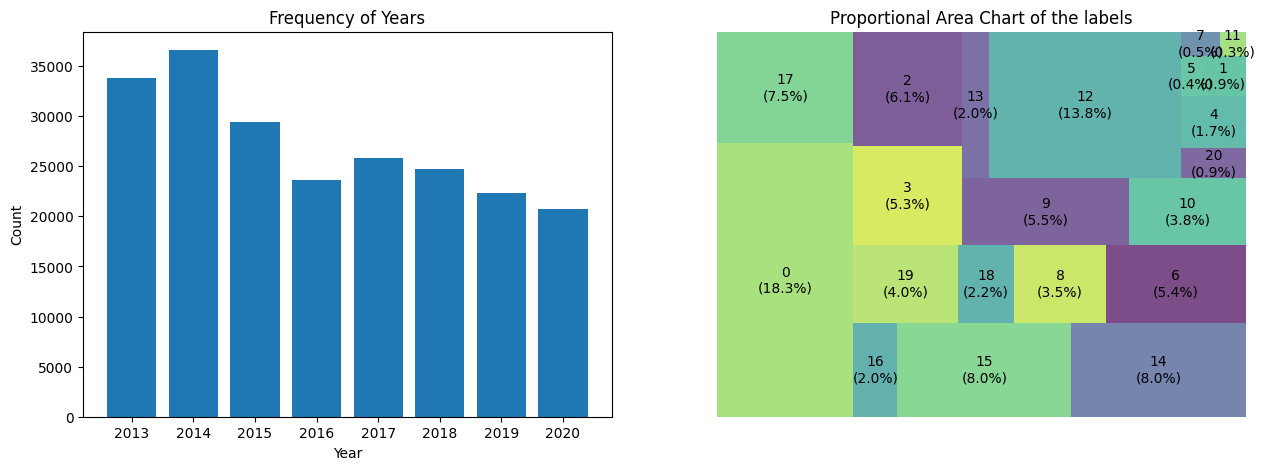

In [9]:
year_counts = Counter(year)
sorted_years = sorted(year_counts)
frequencies_years = [year_counts[year] for year in sorted_years]

lable_counts = Counter(labels)
sorted_lables = sorted(lable_counts)
frequencies_labels = [lable_counts[label] for label in sorted_lables]
labels_with_pct = [f"{label}\n({size/sum(frequencies_labels):.1%})" for label, size in lable_counts.items()]

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].bar(sorted_years, frequencies_years)
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Count')
ax[0].set_title('Frequency of Years')


squarify.plot(sizes=lable_counts.values(), label=labels_with_pct, alpha=0.7, ax=ax[1])
ax[1].axis('off')
ax[1].set_title("Proportional Area Chart of the labels")

# ax[1].bar(sorted_lables, frequencies_labels)
# ax[1].set_xlabel('Label')
# ax[1].set_ylabel('Count')
# ax[1].set_title('Label Frequencies')

plt.show()

## Convert texts to TF-IDF vectors

In [40]:
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(preprocessed_texts).toarray()
y = np.array(labels)

## Create a PyTorch dataset

In [11]:
class TextDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

train_dataset = DataLoader(TextDataset(X_train, y_train), batch_size=32, shuffle=True)
test_dataset = DataLoader(TextDataset(X_test, y_test), batch_size=32)

# Basic NN

## Model Class

In [28]:
# Define the FCNN model
class FCNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

## Initialize Model, Loss and Optimizer

In [29]:
fcnn = FCNN(input_size=1000, hidden_size=256, num_classes=21)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fcnn.parameters(), lr=0.001)

## Training and Testing

In [30]:
def train(model, train_loader, optimizer, history):
    model.train()
    running_loss, running_correct, running_total = 0.0, 0, 0

    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        running_loss   += loss.item() * target.size(0)
        running_correct += output.argmax(1).eq(target).sum().item()
        running_total  += target.size(0)

    history["train_loss"].append(running_loss / running_total)
    history["train_accuracy"].append(100.0 * running_correct / running_total)


def test(model, test_loader, history):
    model.eval()
    running_loss, running_correct, running_total = 0.0, 0, 0

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            running_loss   += loss_function(output, target).item() * target.size(0)
            running_correct += output.argmax(1).eq(target).sum().item()
            running_total  += target.size(0)

    history["val_loss"].append(running_loss / running_total)
    history["val_accuracy"].append(100.0 * running_correct / running_total)

## History plot

In [16]:
def plot_history(n_epochs, history):
    plt.style.use("ggplot")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle("Training Loss and Accuracy")

    # Accuracy plot
    ax1.plot(np.arange(n_epochs), history["train_accuracy"], label="train")
    ax1.plot(np.arange(n_epochs), history["val_accuracy"], label="val")
    ax1.set_title("Accuracy")
    ax1.set_xlabel("Epoch #")
    ax1.set_ylabel("Accuracy (%)")
    ax1.legend(loc="lower right")

    # Loss plot
    ax2.plot(np.arange(n_epochs), history["train_loss"],     label="train")
    ax2.plot(np.arange(n_epochs), history["val_loss"], label="val")
    ax2.set_title("Loss")
    ax2.set_xlabel("Epoch #")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="upper right")

    plt.show()

## Fitting function

In [21]:
def fit(model, train_loader, test_loader, optimizer, epochs):
    history = {k: [] for k in ["train_loss", "train_accuracy", "val_loss", "val_accuracy"]}

    for epoch in range(epochs):
        train(model, train_loader, optimizer, history)
        test(model,  test_loader,  history)

        print(f"Epoch {epoch+1:02d}/{epochs} │ "
              f"loss={history['train_loss'][-1]:.4f}  "
              f"val_loss={history['val_loss'][-1]:.4f}  "
              f"acc={history['train_accuracy'][-1]:.2f}%  "
              f"val_acc={history['val_accuracy'][-1]:.2f}%")

    plot_history(epochs, history)
    return history

## Run model

Epoch 01/20 │ loss=0.2920  val_loss=0.1798  acc=91.95%  val_acc=94.55%
Epoch 02/20 │ loss=0.1623  val_loss=0.1701  acc=94.98%  val_acc=94.82%
Epoch 03/20 │ loss=0.1423  val_loss=0.1636  acc=95.48%  val_acc=95.14%
Epoch 04/20 │ loss=0.1262  val_loss=0.1626  acc=95.97%  val_acc=95.16%
Epoch 05/20 │ loss=0.1118  val_loss=0.1640  acc=96.39%  val_acc=95.27%
Epoch 06/20 │ loss=0.0992  val_loss=0.1654  acc=96.73%  val_acc=95.25%
Epoch 07/20 │ loss=0.0876  val_loss=0.1688  acc=97.13%  val_acc=95.28%
Epoch 08/20 │ loss=0.0774  val_loss=0.1731  acc=97.42%  val_acc=95.25%
Epoch 09/20 │ loss=0.0683  val_loss=0.1773  acc=97.72%  val_acc=95.29%
Epoch 10/20 │ loss=0.0605  val_loss=0.1852  acc=97.98%  val_acc=95.34%
Epoch 11/20 │ loss=0.0541  val_loss=0.1903  acc=98.19%  val_acc=95.33%
Epoch 12/20 │ loss=0.0485  val_loss=0.2000  acc=98.36%  val_acc=95.27%
Epoch 13/20 │ loss=0.0445  val_loss=0.2050  acc=98.47%  val_acc=95.21%
Epoch 14/20 │ loss=0.0404  val_loss=0.2159  acc=98.60%  val_acc=95.22%
Epoch 

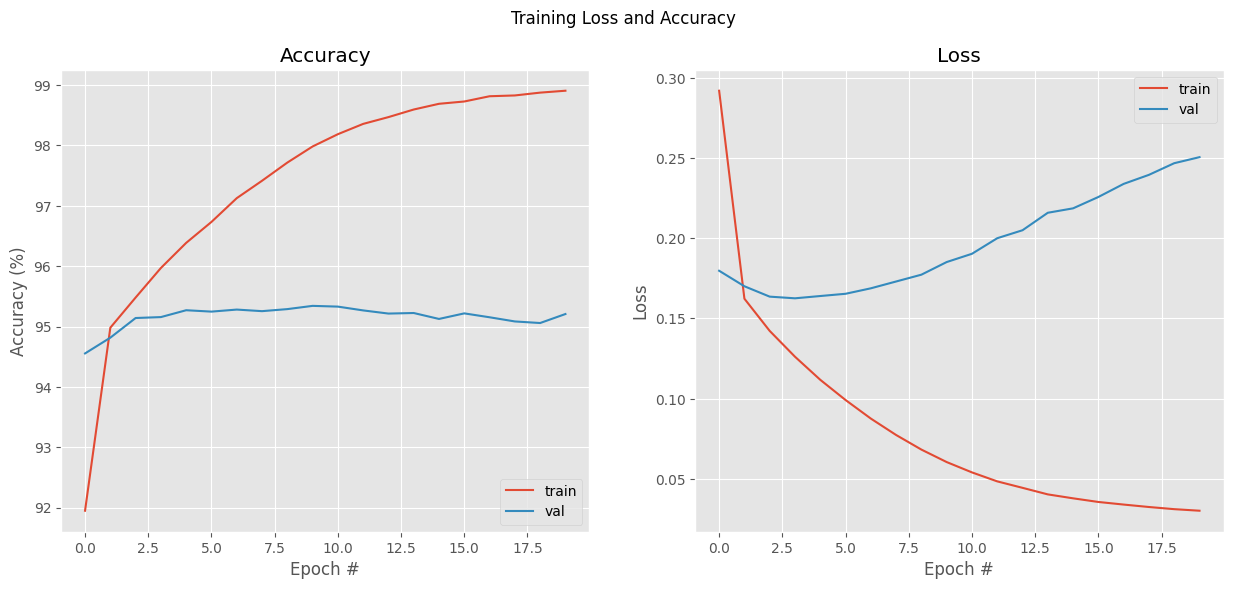

In [31]:
history = fit(
    model        = fcnn,
    train_loader = train_dataset,
    test_loader  = test_dataset,
    optimizer    = optimizer,
    epochs       = 20
)

There are clear overfitting issues with this model.

# Transformer model

In [24]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import evaluate
import accelerate

Hugging face BERT-like models expects tokenized inputs (This is done by lazy-tokenization):

In [34]:
df = pd.DataFrame({
    "text": preprocessed_texts,
    "label": labels
})

train_tok, test_tok = train_test_split(df, test_size=0.25,
                                       stratify=labels, random_state=0)

train_tok = Dataset.from_pandas(train_tok)
test_tok   = Dataset.from_pandas(test_tok)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch['text'],
                     padding='max_length',
                     truncation=True
                     )

# Convert to HuggingFace Dataset object to be able to use .map()
# train_dataset = Dataset.from_dict({"text": X_train_tok, "label": y_train_tok})
# test_dataset  = Dataset.from_dict({"text": X_test_tok,  "label": y_test_tok})
train_tok = train_tok.map(tokenize)
test_tok  = test_tok.map(tokenize)

train_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map: 100%|██████████| 54244/54244 [00:10<00:00, 5329.54 examples/s]


APUNTAR EN EL PPT QUÈ MERDES ÉS EL BERT-BASE-UNCASED:

- **BERT** stands for **Bidirectional Encoder Representations from Transformers**.

- It’s a pretrained Transformer-based model developed by Google in 2018.

- Designed to understand language **bidirectionally** (looking at context from both left and right).

- `"base"` means it’s the smaller version of BERT (compared to `bert-large`).

- `"uncased"` means it does not distinguish uppercase and lowercase letters — input text is lowercased before tokenization.


When to Use:
- Great general-purpose language model.

- Lowercased text input, so works best on texts that are not case-sensitive.

- Efficient enough for many applications while maintaining strong performance.

Model Specs:

| Feature                | Description                 |
|------------------------|-----------------------------|
| Layers (Transformer blocks) | 12                      |
| Hidden size            | 768                         |
| Attention heads        | 12                          |
| Parameters             | ~110 million                |
| Vocabulary size        | 30,522 tokens               |
| Max input length       | 512 tokens                  |

In [35]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=21,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainer wrapping (so it can be used as a sklearn-like model)

In [38]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=preds, references=labels)

args = TrainingArguments(
    output_dir="outputs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    num_train_epochs=2,           # 2-3 epochs usually fine when fine-tuning
    fp16=True,
    seed=42,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=test_tok,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

Run model

In [39]:
trainer.train()
trainer.evaluate()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.211900,0.201387,0.954742
2,0.147700,0.162076,0.963093


{'eval_loss': 0.16207608580589294,
 'eval_accuracy': 0.9630926922793305,
 'eval_runtime': 136.7285,
 'eval_samples_per_second': 396.728,
 'eval_steps_per_second': 49.595,
 'epoch': 2.0}

FINAL NOTES: since the transformer model DOES NOT perform better than the FCNN, we will modify the FCNN in order to reduce the overfitting issue. We will also try training using per-year data and see its performance when predicting the following year data.

# FCNN: Dealing with overfitting

## Adding Dropout layer and Batch Normalization

`Dropout` randomly disables some neurons during training, forcing the model to generalize better whereas `Batch Normalization` helps in stabilizing and regularizing the training, especially in deeper networks.

Epoch 01/20 │ loss=0.3481  val_loss=0.1881  acc=90.51%  val_acc=94.48%
Epoch 02/20 │ loss=0.2386  val_loss=0.1750  acc=93.16%  val_acc=94.79%
Epoch 03/20 │ loss=0.2168  val_loss=0.1695  acc=93.65%  val_acc=94.91%
Epoch 04/20 │ loss=0.1992  val_loss=0.1651  acc=94.18%  val_acc=95.15%
Epoch 05/20 │ loss=0.1903  val_loss=0.1635  acc=94.39%  val_acc=95.18%
Epoch 06/20 │ loss=0.1813  val_loss=0.1620  acc=94.54%  val_acc=95.22%
Epoch 07/20 │ loss=0.1715  val_loss=0.1665  acc=94.78%  val_acc=95.02%
Epoch 08/20 │ loss=0.1686  val_loss=0.1628  acc=94.88%  val_acc=95.30%
Epoch 09/20 │ loss=0.1620  val_loss=0.1609  acc=95.06%  val_acc=95.35%
Epoch 10/20 │ loss=0.1570  val_loss=0.1609  acc=95.16%  val_acc=95.34%
Epoch 11/20 │ loss=0.1528  val_loss=0.1630  acc=95.31%  val_acc=95.26%
Epoch 12/20 │ loss=0.1496  val_loss=0.1597  acc=95.31%  val_acc=95.40%
Epoch 13/20 │ loss=0.1464  val_loss=0.1623  acc=95.45%  val_acc=95.46%
Epoch 14/20 │ loss=0.1450  val_loss=0.1604  acc=95.51%  val_acc=95.48%
Epoch 

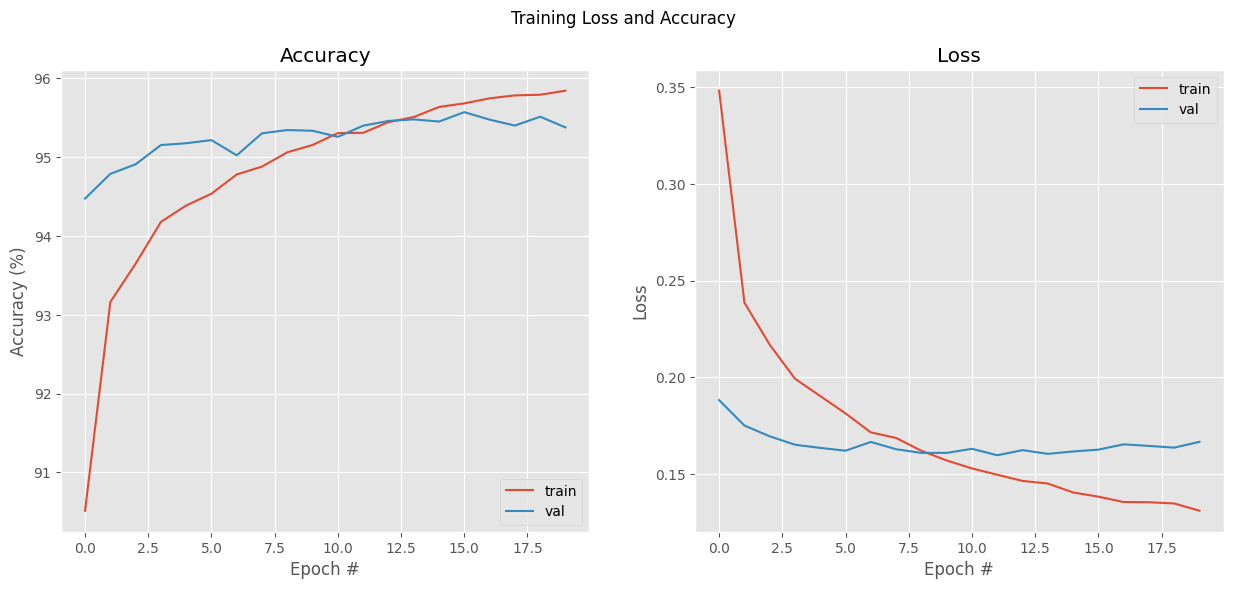

In [24]:
class FCNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)

        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        out = self.fc3(out)

        return out

fcnn = FCNN(input_size=1000, hidden_size=256, num_classes=21)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fcnn.parameters(), lr=0.001)

history = fit(
    model        = fcnn,
    train_loader = train_dataset,
    test_loader  = test_dataset,
    optimizer    = optimizer,
    epochs       = 20
)

We can see the overfitting has improved at the cost of reducing slightly the training accuracy of the model: 98,91 -> 95,84. 

The validation (test) accuracy improves though: 95,21 -> 95,38

## Yearly data distribution for train and testing

Now we will use data from a specific year as the validation set, and data from the previous year as the training set. This approach helps estimate the model’s predictive power on future (unseen) data, simulating how it might perform on the final test set.

Length Traing data: 33770
Length Test data: 36589
Epoch 01/20 │ loss=1.0112  val_loss=5.0874  acc=77.81%  val_acc=22.68%
Epoch 02/20 │ loss=0.6538  val_loss=4.9409  acc=84.26%  val_acc=23.25%
Epoch 03/20 │ loss=0.4726  val_loss=4.8926  acc=87.97%  val_acc=23.51%
Epoch 04/20 │ loss=0.3619  val_loss=4.8852  acc=90.40%  val_acc=23.49%
Epoch 05/20 │ loss=0.2875  val_loss=4.9009  acc=92.14%  val_acc=23.73%
Epoch 06/20 │ loss=0.2337  val_loss=4.9483  acc=93.51%  val_acc=24.25%
Epoch 07/20 │ loss=0.1935  val_loss=4.9783  acc=94.63%  val_acc=23.72%
Epoch 08/20 │ loss=0.1623  val_loss=5.0302  acc=95.42%  val_acc=23.68%
Epoch 09/20 │ loss=0.1384  val_loss=5.0817  acc=96.14%  val_acc=24.15%
Epoch 10/20 │ loss=0.1192  val_loss=5.1346  acc=96.68%  val_acc=24.62%
Epoch 11/20 │ loss=0.1041  val_loss=5.2172  acc=97.12%  val_acc=24.61%
Epoch 12/20 │ loss=0.0917  val_loss=5.3194  acc=97.45%  val_acc=24.91%
Epoch 13/20 │ loss=0.0814  val_loss=5.4257  acc=97.76%  val_acc=24.97%
Epoch 14/20 │ loss=0.0729  

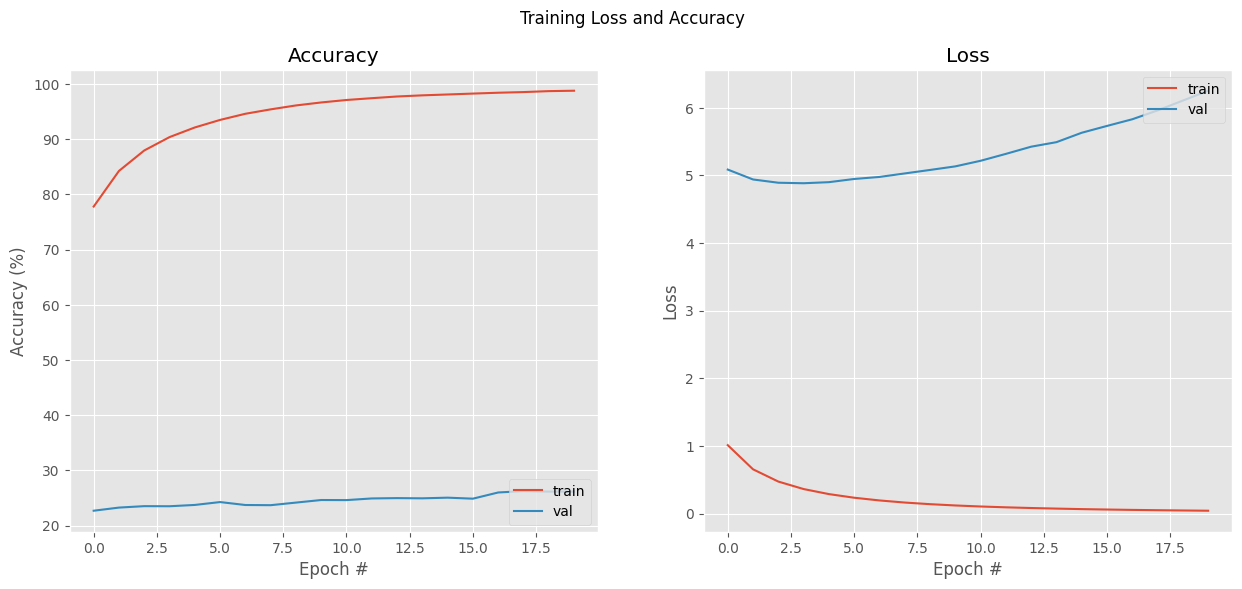

Length Traing data: 70359
Length Test data: 29412
Epoch 01/20 │ loss=1.6170  val_loss=5.9272  acc=68.74%  val_acc=20.18%
Epoch 02/20 │ loss=0.6071  val_loss=5.7963  acc=84.90%  val_acc=19.88%
Epoch 03/20 │ loss=0.4073  val_loss=5.8112  acc=89.38%  val_acc=20.37%
Epoch 04/20 │ loss=0.3070  val_loss=5.8785  acc=91.79%  val_acc=19.85%
Epoch 05/20 │ loss=0.2456  val_loss=5.9738  acc=93.23%  val_acc=19.80%
Epoch 06/20 │ loss=0.2038  val_loss=6.0742  acc=94.20%  val_acc=20.01%
Epoch 07/20 │ loss=0.1739  val_loss=6.2121  acc=94.96%  val_acc=20.12%
Epoch 08/20 │ loss=0.1520  val_loss=6.3892  acc=95.64%  val_acc=20.03%
Epoch 09/20 │ loss=0.1345  val_loss=6.4802  acc=96.12%  val_acc=20.05%
Epoch 10/20 │ loss=0.1207  val_loss=6.6465  acc=96.52%  val_acc=20.25%
Epoch 11/20 │ loss=0.1091  val_loss=6.8959  acc=96.83%  val_acc=20.54%
Epoch 12/20 │ loss=0.0993  val_loss=7.1098  acc=97.08%  val_acc=20.19%
Epoch 13/20 │ loss=0.0911  val_loss=7.3038  acc=97.31%  val_acc=20.17%
Epoch 14/20 │ loss=0.0840  

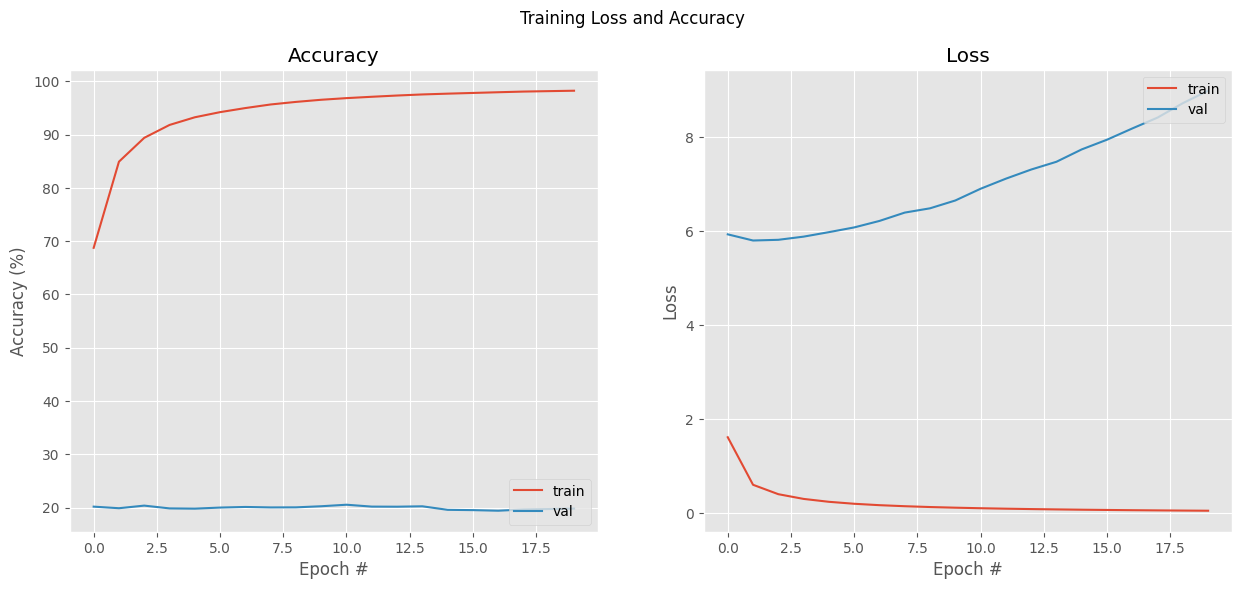

Length Traing data: 99771
Length Test data: 23589
Epoch 01/20 │ loss=1.3389  val_loss=9.1180  acc=73.41%  val_acc=9.61%
Epoch 02/20 │ loss=0.5035  val_loss=8.9914  acc=87.27%  val_acc=8.75%
Epoch 03/20 │ loss=0.3378  val_loss=9.2267  acc=90.92%  val_acc=8.44%
Epoch 04/20 │ loss=0.2577  val_loss=9.3606  acc=92.93%  val_acc=8.55%
Epoch 05/20 │ loss=0.2094  val_loss=9.4975  acc=94.19%  val_acc=8.58%
Epoch 06/20 │ loss=0.1766  val_loss=9.7953  acc=95.02%  val_acc=8.56%
Epoch 07/20 │ loss=0.1529  val_loss=10.0713  acc=95.60%  val_acc=8.58%
Epoch 08/20 │ loss=0.1350  val_loss=10.3969  acc=96.01%  val_acc=8.58%
Epoch 09/20 │ loss=0.1208  val_loss=10.7400  acc=96.38%  val_acc=8.24%
Epoch 10/20 │ loss=0.1092  val_loss=11.1037  acc=96.76%  val_acc=8.69%
Epoch 11/20 │ loss=0.0996  val_loss=11.3628  acc=97.04%  val_acc=8.83%
Epoch 12/20 │ loss=0.0913  val_loss=11.7530  acc=97.27%  val_acc=8.57%
Epoch 13/20 │ loss=0.0844  val_loss=12.1271  acc=97.45%  val_acc=8.56%
Epoch 14/20 │ loss=0.0785  val_lo

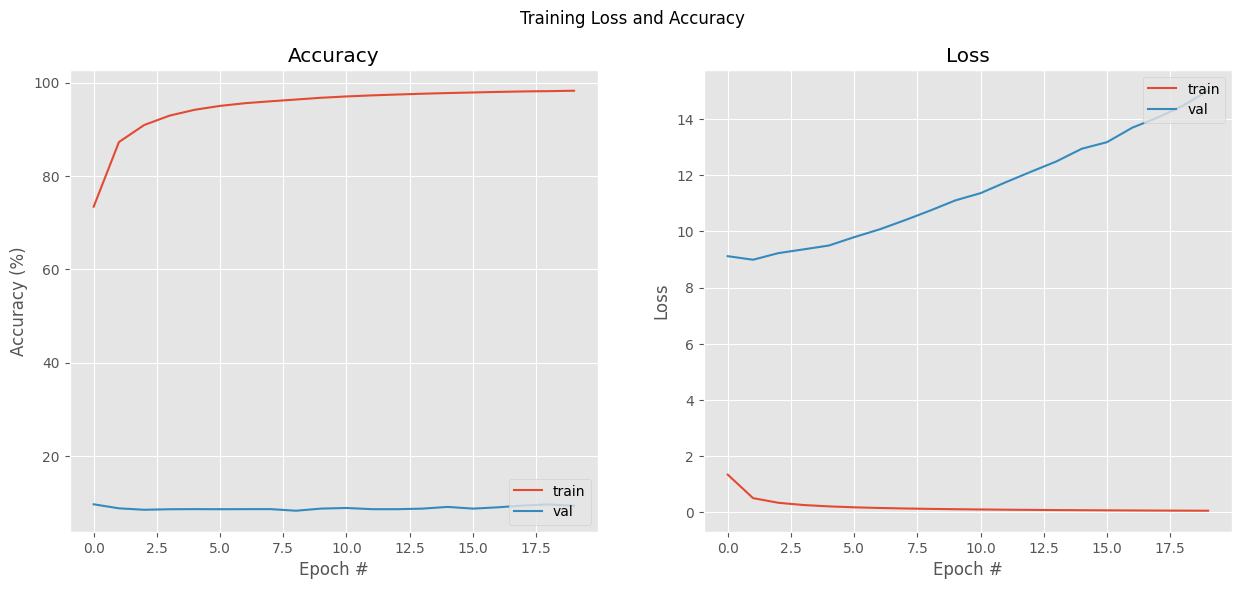

Length Traing data: 123360
Length Test data: 25813
Epoch 01/20 │ loss=1.2869  val_loss=6.5330  acc=74.40%  val_acc=14.52%
Epoch 02/20 │ loss=0.4624  val_loss=6.4540  acc=87.79%  val_acc=13.96%
Epoch 03/20 │ loss=0.3104  val_loss=6.4585  acc=91.32%  val_acc=14.00%
Epoch 04/20 │ loss=0.2386  val_loss=6.6436  acc=93.16%  val_acc=13.88%
Epoch 05/20 │ loss=0.1967  val_loss=6.7819  acc=94.30%  val_acc=13.67%
Epoch 06/20 │ loss=0.1686  val_loss=6.9946  acc=95.06%  val_acc=13.75%
Epoch 07/20 │ loss=0.1483  val_loss=7.1458  acc=95.61%  val_acc=13.97%
Epoch 08/20 │ loss=0.1327  val_loss=7.3466  acc=96.01%  val_acc=14.36%
Epoch 09/20 │ loss=0.1203  val_loss=7.5522  acc=96.36%  val_acc=14.40%
Epoch 10/20 │ loss=0.1102  val_loss=7.7874  acc=96.67%  val_acc=15.00%
Epoch 11/20 │ loss=0.1017  val_loss=8.0074  acc=96.87%  val_acc=15.47%
Epoch 12/20 │ loss=0.0943  val_loss=8.1502  acc=97.12%  val_acc=16.02%
Epoch 13/20 │ loss=0.0881  val_loss=8.4420  acc=97.30%  val_acc=15.64%
Epoch 14/20 │ loss=0.0827 

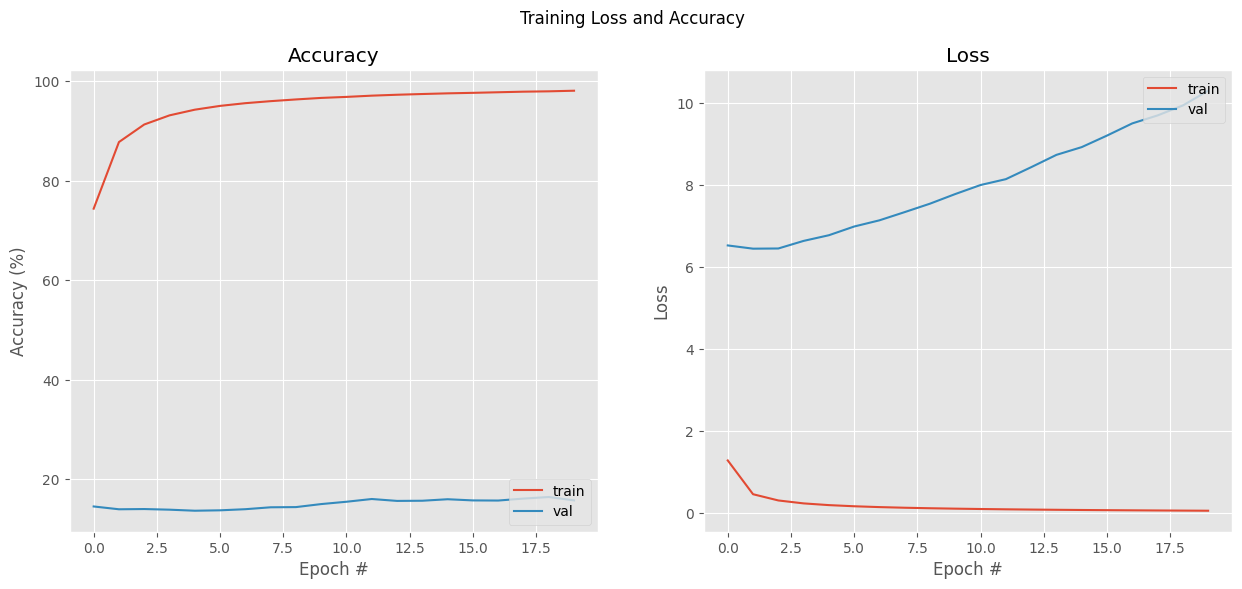

Length Traing data: 149173
Length Test data: 24734
Epoch 01/20 │ loss=1.1894  val_loss=10.3102  acc=76.75%  val_acc=9.49%
Epoch 02/20 │ loss=0.4311  val_loss=10.1051  acc=89.10%  val_acc=9.59%
Epoch 03/20 │ loss=0.2857  val_loss=10.2258  acc=92.30%  val_acc=8.58%
Epoch 04/20 │ loss=0.2180  val_loss=10.5078  acc=93.95%  val_acc=9.05%
Epoch 05/20 │ loss=0.1784  val_loss=10.8229  acc=94.87%  val_acc=8.45%
Epoch 06/20 │ loss=0.1523  val_loss=11.0832  acc=95.56%  val_acc=8.66%
Epoch 07/20 │ loss=0.1337  val_loss=11.3485  acc=96.00%  val_acc=9.38%
Epoch 08/20 │ loss=0.1195  val_loss=11.7948  acc=96.37%  val_acc=8.99%
Epoch 09/20 │ loss=0.1086  val_loss=12.2415  acc=96.68%  val_acc=8.77%
Epoch 10/20 │ loss=0.0997  val_loss=12.5597  acc=96.94%  val_acc=9.25%
Epoch 11/20 │ loss=0.0924  val_loss=12.9697  acc=97.14%  val_acc=9.22%
Epoch 12/20 │ loss=0.0861  val_loss=13.3644  acc=97.34%  val_acc=9.25%
Epoch 13/20 │ loss=0.0807  val_loss=13.8269  acc=97.48%  val_acc=9.15%
Epoch 14/20 │ loss=0.0761 

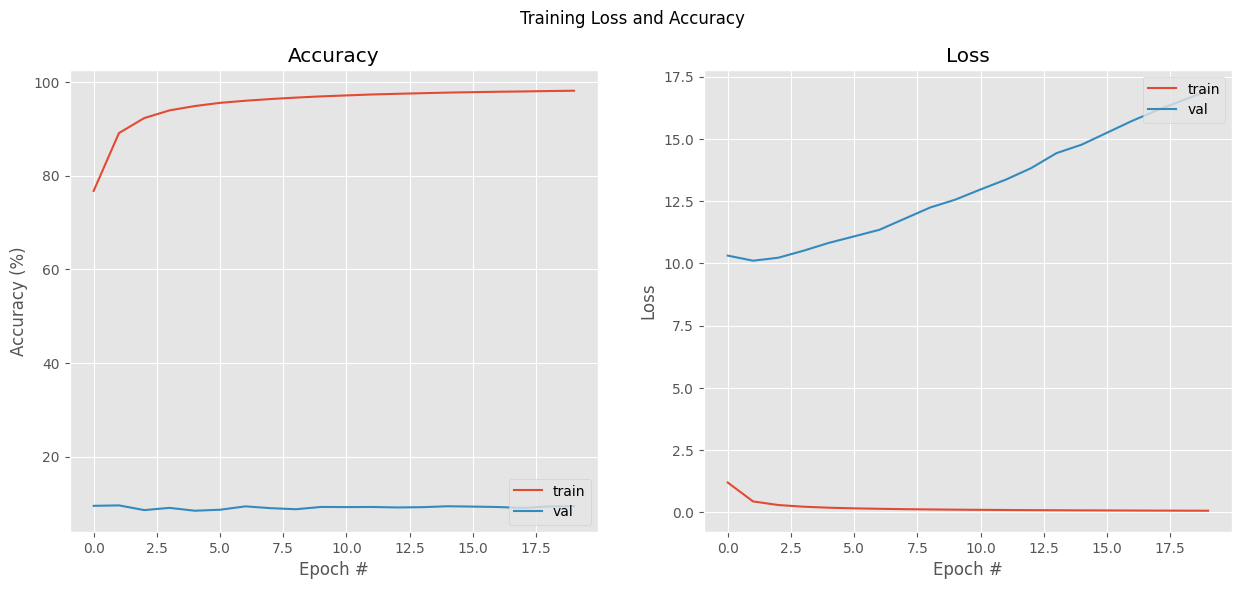

Length Traing data: 173907
Length Test data: 22365
Epoch 01/20 │ loss=1.1350  val_loss=11.8384  acc=77.82%  val_acc=8.44%
Epoch 02/20 │ loss=0.3958  val_loss=11.2854  acc=89.98%  val_acc=8.94%
Epoch 03/20 │ loss=0.2630  val_loss=11.4438  acc=92.88%  val_acc=8.59%
Epoch 04/20 │ loss=0.2031  val_loss=11.5173  acc=94.31%  val_acc=8.15%
Epoch 05/20 │ loss=0.1683  val_loss=11.8205  acc=95.14%  val_acc=8.19%
Epoch 06/20 │ loss=0.1455  val_loss=12.1765  acc=95.73%  val_acc=8.38%
Epoch 07/20 │ loss=0.1293  val_loss=12.6587  acc=96.15%  val_acc=8.81%
Epoch 08/20 │ loss=0.1173  val_loss=12.9615  acc=96.50%  val_acc=8.85%
Epoch 09/20 │ loss=0.1074  val_loss=13.4192  acc=96.76%  val_acc=8.84%
Epoch 10/20 │ loss=0.0994  val_loss=13.9265  acc=96.99%  val_acc=8.88%
Epoch 11/20 │ loss=0.0927  val_loss=14.3781  acc=97.14%  val_acc=8.83%
Epoch 12/20 │ loss=0.0870  val_loss=14.6250  acc=97.31%  val_acc=9.08%
Epoch 13/20 │ loss=0.0818  val_loss=15.0653  acc=97.46%  val_acc=9.00%
Epoch 14/20 │ loss=0.0775 

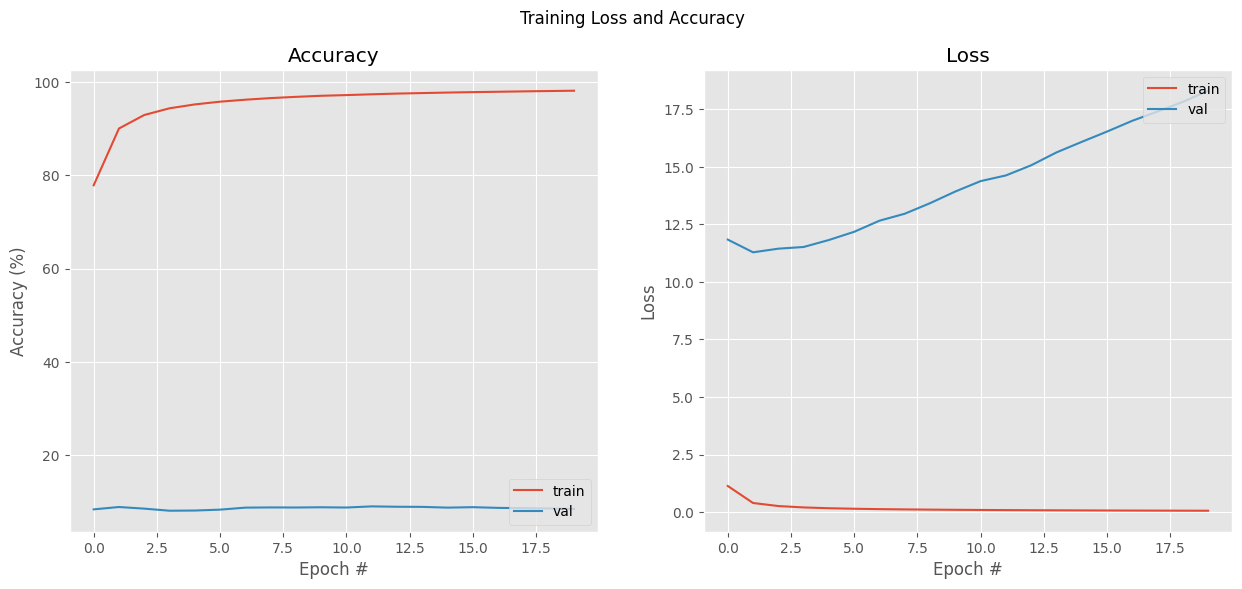

Length Traing data: 196272
Length Test data: 20702
Epoch 01/20 │ loss=0.9934  val_loss=11.6968  acc=80.86%  val_acc=10.47%
Epoch 02/20 │ loss=0.3596  val_loss=11.1724  acc=90.87%  val_acc=8.59%
Epoch 03/20 │ loss=0.2437  val_loss=11.2150  acc=93.36%  val_acc=8.16%
Epoch 04/20 │ loss=0.1913  val_loss=11.3561  acc=94.56%  val_acc=8.14%
Epoch 05/20 │ loss=0.1613  val_loss=11.7897  acc=95.31%  val_acc=8.03%
Epoch 06/20 │ loss=0.1409  val_loss=12.2100  acc=95.85%  val_acc=7.62%
Epoch 07/20 │ loss=0.1263  val_loss=12.5283  acc=96.19%  val_acc=7.87%
Epoch 08/20 │ loss=0.1152  val_loss=12.9144  acc=96.48%  val_acc=7.67%
Epoch 09/20 │ loss=0.1067  val_loss=13.2064  acc=96.73%  val_acc=7.95%
Epoch 10/20 │ loss=0.0994  val_loss=13.6967  acc=96.95%  val_acc=7.54%
Epoch 11/20 │ loss=0.0935  val_loss=14.0574  acc=97.07%  val_acc=7.64%
Epoch 12/20 │ loss=0.0884  val_loss=14.4780  acc=97.24%  val_acc=7.70%
Epoch 13/20 │ loss=0.0839  val_loss=15.0407  acc=97.34%  val_acc=7.81%
Epoch 14/20 │ loss=0.0803

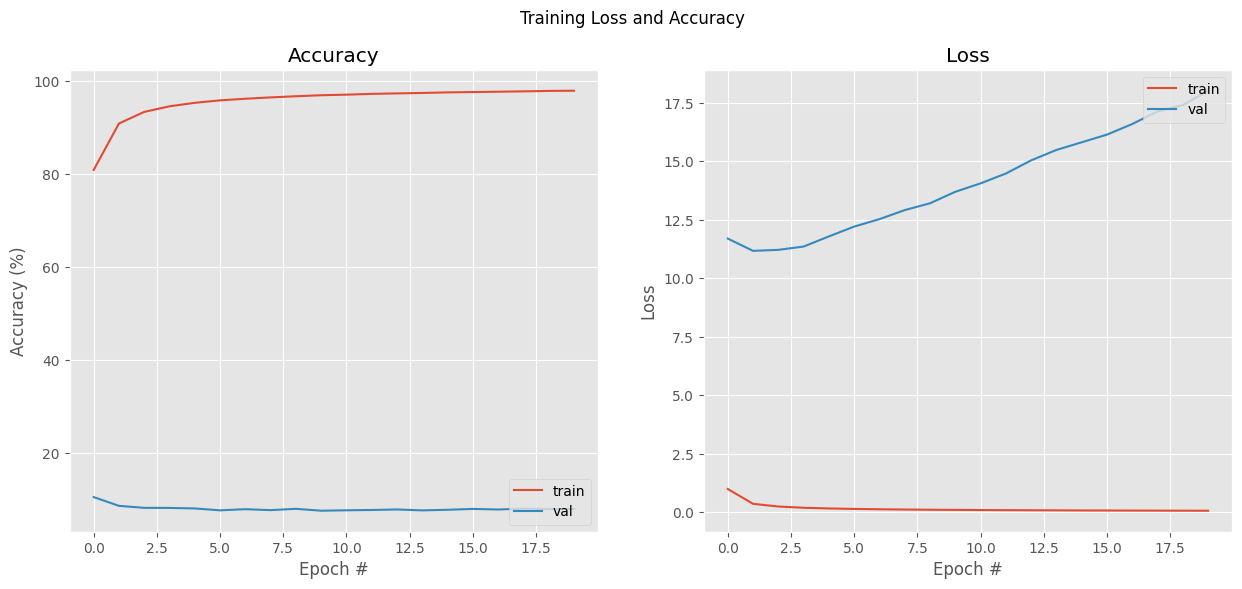

In [44]:
year_num = 2014
val_acc_history = {}

while year_num <= 2020:

    X = vectorizer.fit_transform([text for text, y in zip(preprocessed_texts, year) if y < year_num]).toarray()
    y = np.array([text for text, y in zip(labels, year) if y < year_num])
    print(f'Length Traing data: {len(y)}')
    train_dataset = DataLoader(TextDataset(X, y), batch_size=32, shuffle=True)

    X = vectorizer.fit_transform([text for text, y in zip(preprocessed_texts, year) if y == year_num]).toarray()
    y = np.array([text for text, y in zip(labels, year) if y == year_num])
    print(f'Length Test data: {len(y)}')    
    test_dataset = DataLoader(TextDataset(X, y), batch_size=32)

    history = fit(
    model        = fcnn,
    train_loader = train_dataset,
    test_loader  = test_dataset,
    optimizer    = optimizer,
    epochs       = 20
    )

    val_acc_history[year_num] = history['val_accuracy'][-1]

    year_num += 1

In [45]:
val_acc_history

{2014: 26.149935773046543,
 2015: 19.815041479668164,
 2016: 9.300945355886219,
 2017: 15.747878975709913,
 2018: 9.428317296029757,
 2019: 8.513302034428795,
 2020: 7.907448555695102}